# Simulation of poromechanical processes in a fractured porous medium
This noteboook aims to give an overview of the problem of poromechanical deformation of
a fractured porous media, and how this can be simulated in 2d. 

Please note that we assume the reader has already gone through the notebook on
mixed-dimensional flow problems.


## Governing equations
PorePy simulates mechanical deformation of a porous media, denoted $\Omega_M$ as a coupled system with 
conservation of momentuum and mass. Using the displacement $u$ and the fluid pressure $p$
as primary variables, the conservation equations are 
$$\nabla \cdot \sigma = \nabla\cdot (\mathbb{C} \epsilon - I\alpha p_m) = f_s $$
for momentum and 
$$\frac{\partial \rho\phi}{\partial t} - \nabla\cdot (\rho K \nabla p_m) = f_f$$
for mass.

Here, $\sigma$ is the stress, $\mathbf{C}$ is the stiffness matrix, $\epsilon$ the
symmetrized displacement gradient, $I$ an identity tensor and $f_s$ body forces.
Moreover, $\rho$ represents fluid density, $\phi$ porosity, $K$ permeability,  
$f_f$ fluid sources and sinks, and the subscript $m$ on the pressure marks that this is the pressure in the matrix.
In addition come initial and boundary conditions; we will for simplicity disregard these.

Next, we introduce a fracture $\Omega_F$ and let $\Gamma$ represent the interface between $\Omega_M$ and $\Omega_F$.
The model for fluid flow in the fracture is the same as in the notebook for mixed
dimensional flow, and we will not review it here.
For the mechanical behavior, we introduce the contact stress $T$ as

$$T = n\cdot(\mathbb{C}\epsilon - I p_m) - p_f I \cdot n $$

Here, $n$ is a vector normal to the fracture.
The model for the deformation of the fracture consists of three components. 
First, balance of forces across the fractures, which reads

$$T^+ + T^- = 0$$

Where superscripts $+$ and $-$ denote the two sides of the fracture.
Second, in the normal direction of the fracture, there are two possible configurations:
Either, the fracture is open (the walls are not in contact) and the contact force is zero,
or the walls are in contact and the force is potentially non-zero.
Mathematically this can be expressed as

$$ [u]_n\geq 0 \qquad [u]_n T_n = 0 \qquad T_n \leq 0 $$

where subscript $n$ represents the normal component of a vector and $[u]$ is the displacement
jump across the fracture.

Third, motion in the tangential direction of the fracture is restricted by a Coulomb-type friction law:
There will be no motion as long as the tangential forces are insufficient to overcome the
frictional resistance, but if this is overcome, the displacement jump in the tangential
direction will change (note: we do not resolve the actual movement of the walls, but 
only search for the next static condition). This is expressed in terms of the following
equations:

$$

\begin{align}
    ||T_\tau||&\leq - F T_n \\
    ||T_\tau||&< - F T_n \Rightarrow [u]_\tau =0\\
    ||T_\tau||&= - F T_n \Rightarrow \exists \,\zeta \in \mathbb{R^+}: [u]_\tau = \zeta T_\tau.
\end{align}

$$

where $F$ represents the coefficient of friction and subscript $\tau$ denotes the
tangential component of a vector.

We see that this is a problem of considerabe difficulty: Not only is the problem non-linear,
which equations we have to solve actually depends on the solution. This is an example of
a class of problems known as variational inequalities. Fortunately, PorePy has implemented
methods to deal with these problems, and it is to implementational aspects we now turn.


## Implementation
To construct a PorePy simulation model for poromechanical fracture deformation, we proceed
in much the same way as we did for the flow problem, except that the template model
that we will expand on is `pp.poromechanics.Poromechanics`.

The first step is to define a geometry class that sets a fracture network. For this, we
simply copy the relevant function from the flow notebook.

In [1]:
# First the usual imports
import porepy as pp
import numpy as np

# We will use the same mesh as in the flow problem
class GeometryWithFractures(pp.ModelGeometry):
    # We need to make a class which inherits from the class pp.ModelGeometry (if you don't
    # know what inheritance means, you just have to accept this for now, but do google
    # inheritance in object oriented programing at some point).

    def set_fracture_network(self):
        # The class pp.ModelGeometry has several useful methods that we will leave
        # unaltered, but we do need to change the method which specifies the geometry.
        #
        # The code below is copied from above, except from a crucial modification in the
        # last line.
        #
        # PorePy has a built-in system to change units (for instance, measure
        # distance in milimeters rather than meters) and make sure this is done
        # consistently throughout the equations in a model. This typically requires
        # some boilerplate, like the one we use below. Strictly speaking, it is not
        # needed here, since our domain is of unit size, but it is good pracice to get
        # used to this anyhow.
        length_scaling = 1 / self.units.m

        # Define the domain. The easiest option here is to set a box-shaped domain,
        # specified by its min and max coordinates.
        domain = pp.Domain({'xmin': 0,
                            'xmax': 1 * length_scaling,
                            'ymin': 0,
                            'ymax': 1 * length_scaling
                            })

        # A line fracture is defined by its endpoints, specified in the form of a numpy list.append
        # The first row defines the x-coordinates, the second the y-coordinates, so this fracture
        # runs from (0.3, 0.4) to (0.7, 0.6).
        frac_1 = pp.LineFracture(np.array([[0.3, 0.7], [0.4, 0.6]]) * length_scaling)

        # We can define a second fracture. This will cross the first one in (0.5, 0.5)
        frac_2 = pp.LineFracture(np.array([[0.4, 0.6], [0.3, 0.7]]) * length_scaling,)

        # Add a third fracture which extends outside the domain
        frac_3 = pp.LineFracture(np.array([[0.8, 1.2], [0.8, 1.2]]) * length_scaling,)

        # Collect all fractures in a list
        fracture_set = [frac_1, frac_2, frac_3]

        # Define the fracture network, and assign it to the attribute
        # self.fracture_network
        self.fracture_network = pp.FractureNetwork2d(fracture_set, domain=domain)

    def mesh_arguments(self) -> dict:
        # We also need to set the mesh size arguments. These are also scaled with length
        length_scaling = 1 / self.units.m
        return {'mesh_size_min': 0.03 * length_scaling,
                'mesh_size_bound': 0.2 * length_scaling,
                'mesh_size_frac': 0.1 * length_scaling
                }

The default settings poromechanics model are much the same as for the flow problem in that
they do not give very interesting results. Neveretheless, we define a model class and
solve a problem, just so that we can make a contrast later on.

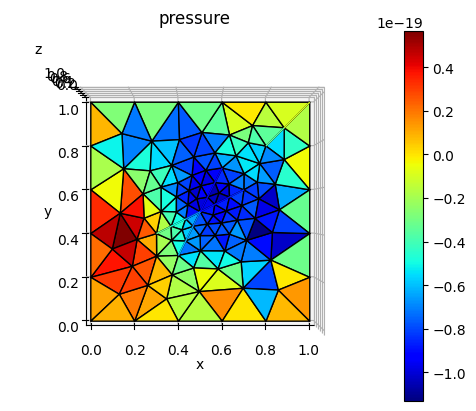

/workspaces/dev/porepy/src/porepy/viz/plot_grid.py:198: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


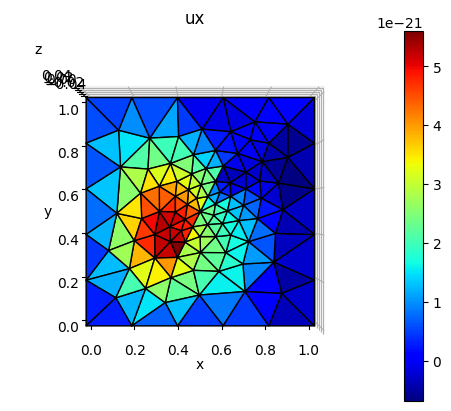

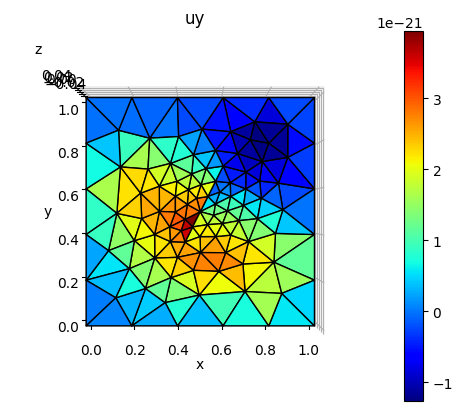

In [30]:
class BoringPoroMechanics(GeometryWithFractures, pp.poromechanics.Poromechanics):
    pass

# Create a model object
boring_model = BoringPoroMechanics()
# Run the model
pp.run_time_dependent_model(boring_model, params={})

# Plot the pressure solution, just as we did for the flow problem.
pp.plot_grid(boring_model.mdg, 'pressure', title='pressure')

# We can also plot the deformation, but this becomes a bit more complex: The deformation
# has two degrees of freedom per cell, so it will not fit neatly into the simple 
# plot_grid() function. There are probably many ways of dealing with this, but we go for
# a solution which works nicely, although it may not be very efficient

def plot_displacement(model):
    # Make a function out of this, so that we can use it also for other models below.
    #
    # The first thing to note is that the displacement is only defined in the porous
    # media, not on the fracture. Therefore, we need to get hold of the grid of the
    # top-dimensional subdomain
    sd = model.mdg.subdomains(dim=model.nd)[0]
    # Fetch the data dictionary
    data = model.mdg.subdomain_data(sd)
    # The computed displacement variable is stored in the data dictionary
    u = data[pp.STATE][model.displacement_variable]
    # The displacement variable contains the x-, then the y- component in the first cell,
    # next, the x- and y-component in the second cell and so on.
    # Slice the displacement vector to get component-wise displacements
    ux = u[0::model.nd]
    uy = u[1::model.nd]

    # When we plot on a single subdomain, we need to pass the values directly to the
    # plotting function.
    pp.plot_grid(sd, ux, title='ux')
    pp.plot_grid(sd, uy, title='uy')


# Plot the displacements.
plot_displacement(boring_model)


You may get a highly oscillating pressure field, but note the range of the color bars: In practice, these are all zero.

Next, let us change the boundary conditions for the mechanics. The template sets zero Dirichlet conditions (e.g., no displacement) on all sides, 
but we will change this to specifying forces on the right and top boundary.

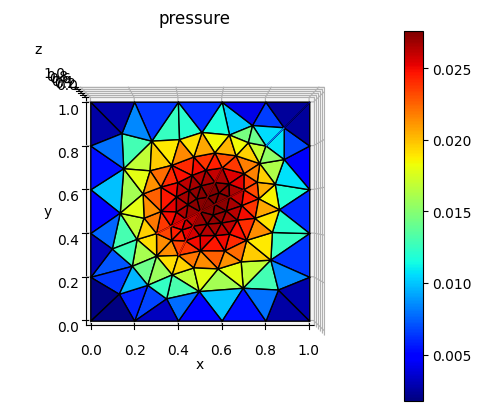

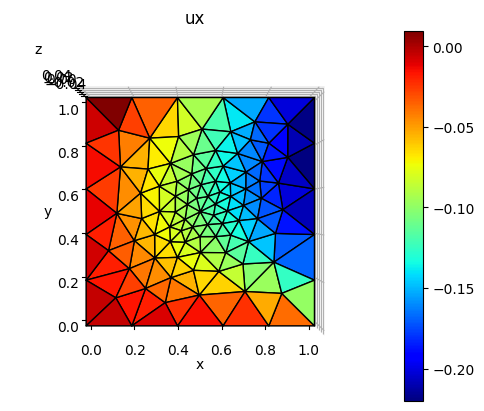

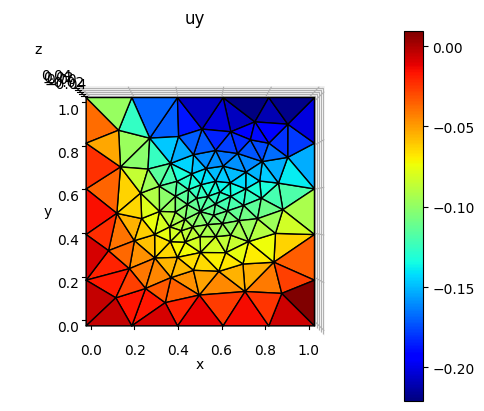

In [38]:
class ModifiedBoundaryCondition(pp.poromechanics.BoundaryConditionsPoromechanics):

    def bc_type_mechanics(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        # Copied from pp.momentum_balance.BoundaryConditionsMomentumBalance

        # Get hold of the domain boundary
        domain_boundary = self.domain_boundary_sides(sd)

        # Set Dirichlet boundary conditions on the left and bottom faces. The other
        # faces are Neumann by default.
        left_faces = np.where(domain_boundary.west)[0]
        bottom_faces = np.where(domain_boundary.south)[0]
        boundary_faces = np.hstack((left_faces, bottom_faces))
        bc = pp.BoundaryConditionVectorial(sd, boundary_faces, "dir")

        # Default internal BC is Neumann. We change to Dirichlet for the contact
        # problem. I.e., the mortar variable represents the displacement on the fracture
        # faces.
        # DO NOT CHANGE THIS! It will break the contact mechanics formulation.
        bc.internal_to_dirichlet(sd)
        return bc

    def bc_values_mechanics(self, subdomains: list[pp.Grid]) -> pp.ad.DenseArray:
        # This method should only be called by the top-dimensional domain, as this is
        # the only one that has such boundary conditions.
        assert len(subdomains) == 1
        sd = subdomains[0]

        # We plan to set forces on the right and top faces; on the other faces, the
        # boundary condition is zero.
        domain_boundary = self.domain_boundary_sides(sd)
        right_faces = domain_boundary.east
        top_faces = domain_boundary.north

        # Vector to store the boundary condition values. Note the dimension: For now
        # we represent it as a 2 x num_faces array, but it will be converted to a
        # 1d array of length 2 * num_faces before being returned.
        values = np.zeros((sd.dim, sd.num_faces))

        # The boundary condition is a vector, so we need to specify the values for
        # each component. Since we are setting Neuamn boundary conditions, we need to
        # set values that are scaled with the area of the face (think of this as setting
        # a total force on the face, rather than a force per unit area).
        # The sign convention is also important: A force is positive if it is directed
        # in the positive direction of the coordinate system. Here we want compression
        # on the right and top faces, so we set negative values.
        values[0, right_faces] = -sd.face_areas[right_faces]
        values[1, top_faces] = -sd.face_areas[top_faces]

        # Convert to a 1d array. The "F" argument means that the array is flattened
        # column-wise, rather than row-wise. In this way, the returned values first has
        # all components for the first face, then all components for the second face,
        # and so on.
        values = values.ravel("F")

        return pp.wrap_as_ad_array(values, "bc_vals_mechanics")
    

# Define a new class which also uses the modified boundary condition
class ModifiedPoromechanics(GeometryWithFractures,
                             ModifiedBoundaryCondition,
                               pp.poromechanics.Poromechanics):
    pass

# Create a model object
modified_model = ModifiedPoromechanics()
# Run the model
pp.run_time_dependent_model(modified_model, params={})
# Plot the pressure solution
pp.plot_grid(modified_model.mdg, 'pressure', title='pressure')

plot_displacement(modified_model)
    

We can note that both components of the displacement seem to be continuous over the fratures.
We can also compute the displacement jump directly. Again, this can be done in several ways,
the below function uses the system for building equations inside the model. This leads to
some boilerplate (which it may take a considerable effort to fully digest), so we wrap
it into a function to be reused.

In [42]:
def evaluate_displacement_jumps(model):
    # First pick out all the fracture subdomains in the model.
    fracture_subdomains = model.mdg.subdomains(dim=model.nd-1)

    # Now we need to enter the equation building system. Model templates which deal with
    # contact mechanics will have a function to compute displacement jumps. Note that the
    # argument needs to be a list of subdomains, so if you want to consider a single
    # subdomain, you can pass fracture_subdomains[:1] (which will be a list), but not
    # fracture_subdomain[0] (which will only be a subdomain grid).
    jump = model.displacement_jump(fracture_subdomains)

    # The tangential and normal components can be extracted by invoking other functions
    # in the templates
    tangential_jump = model.tangential_component(fracture_subdomains) @ jump
    normal_jump = model.normal_component(fracture_subdomains) @ jump

    # Evaluate the jumps and print out the values 
    tang_val = tangential_jump.evaluate(model.equation_system).val
    normal_val = normal_jump.evaluate(model.equation_system).val

    print(f'Tangential jump: {tang_val}')
    print(f"Normal jump: {normal_val}")

evaluate_displacement_jumps(modified_model)

Tangential jump: [ 1.38777878e-17  0.00000000e+00  1.38777878e-17 -6.93889390e-18
 -6.93889390e-18 -2.77555756e-17 -1.38777878e-17  0.00000000e+00
  0.00000000e+00  1.38777878e-17  1.38777878e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Normal jump: [-1.38777878e-17  4.16333634e-17  2.77555756e-17 -1.38777878e-17
 -1.38777878e-17  1.38777878e-17  2.77555756e-17  0.00000000e+00
  2.08166817e-17  6.93889390e-18 -1.38777878e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


We see that all jumps in both directions are practically zero, which means that the fractures are in contact and sticking. To get a non-zero jump, we can either manipulate the effective force on the fracture walls (say, through changing boundary conditions or manipulate the fluid pressure), or we can change the friction coefficient. To show the point, we do the latter:

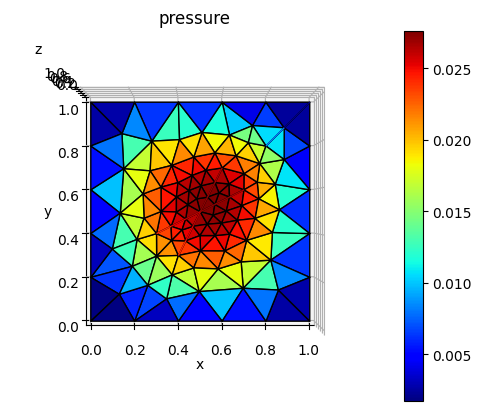

/workspaces/dev/porepy/src/porepy/viz/plot_grid.py:198: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


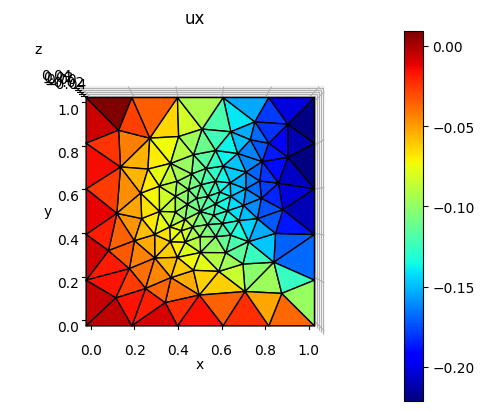

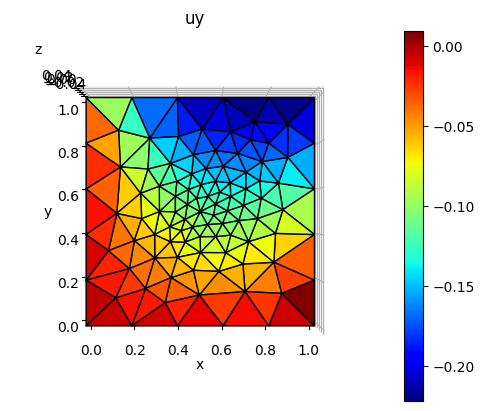

Tangential jump: [-1.21104357e-02 -1.46902331e-02 -1.49054792e-02 -3.06298411e-04
  0.00000000e+00  0.00000000e+00  1.20312054e-02  1.46295303e-02
  1.48626417e-02  2.67969931e-04  1.38777878e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Normal jump: [ 0.00000000e+00 -2.77555756e-17 -4.16333634e-17 -1.38777878e-17
  0.00000000e+00  0.00000000e+00 -3.46944695e-18 -2.77555756e-17
 -6.93889390e-18  2.77555756e-17  4.16333634e-17 -2.77555756e-17
  0.00000000e+00  0.00000000e+00]


In [43]:
class ModifiedFrictionCoefficient(pp.constitutive_laws.FracturedSolid):
    # Modify the friction coefficient by altering the relevant constitutive law

    def friction_coefficient(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        # Set a scalar value of 0.1, and wrap it into a object suited for automatic
        # differentiation.
        return pp.ad.Scalar(0.1)


class ModelWithModifiedFriction(ModifiedBoundaryCondition, 
                                ModifiedFrictionCoefficient,
                                GeometryWithFractures,
                                pp.poromechanics.Poromechanics):
    pass

# Create a model, run it, plot values and also print out displacement jumps
model_with_friction = ModelWithModifiedFriction()
pp.run_time_dependent_model(model_with_friction, params={})
pp.plot_grid(model_with_friction.mdg, 'pressure', title='pressure')
plot_displacement(model_with_friction)
evaluate_displacement_jumps(model_with_friction)

As expected (?), the normal jump did not change, but the tangential jump is no longer zero.

## What next?
The main driving force for the setup has been the boundary conditions, with the fluid playing a secondary part.
For applications we are often interested 

## Want to know more?


## Exercises
1. Try to modify the boundary condition instead of the friction coefficient. Can you make displacement jump non-zero in this way?
2. Define an anisotropic stress field (say, set the boundary stress in the x-direction larger than the one in the y-direction). Set up a problem with a single fracture, and try to vary its angle with the coordinate axes. Are there angles in which the fracture is more prone to sliding?